In [19]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import imageio
from PIL import Image


In [20]:
def create_directory(directory_name):
    '''Create a new directory and verify if it doesn't already exist
    '''

    try:
        # Create a directory
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")

In [21]:
IMAGE_DIR = "../dataset/training/images/"
IMAGE_DIR_AUGMENTED = "../dataset/training/augmented_images/"
GT_DIR = "../dataset/training/groundtruth/"
GT_DIR_AUGMENTED = "../dataset/training/augmented_groundtruth/"


# Creates the augmented directory if it doesn't already exist
create_directory(IMAGE_DIR_AUGMENTED)
create_directory(GT_DIR_AUGMENTED)

Directory '../dataset/training/augmented_images/' created successfully.
Directory '../dataset/training/augmented_groundtruth/' created successfully.


### Helper function

In [22]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def load_image_web(url):
    ### THIS DOES NOT WORK !!!
    ###data = np.array(PIL.Image.open(urllib.request.urlopen(url)))
    # We use that even if it is deprecated
    data = mpimg.imread(url)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

### Loading the images

In [23]:
files = os.listdir(IMAGE_DIR)
n = min(100, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(IMAGE_DIR + files[i]) for i in range(n)]
print(files[0])

print("Loading " + str(n) + " images")
gt_imgs = [load_image(GT_DIR + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_069.png
Loading 100 images
satImage_069.png


In [24]:
type(imgs)

list

### Data augmentation

In [25]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


#### By Rotation

In [26]:
def data_augmentation_rotation(image, groundtruth, degree = 90):
    '''Create new image by image rotation
    Arguments : 
        - image : input image of shape (H,W) that we want to augment
        - groundtruth : segmentation map of the corresponding input image
        - degree : value of the degree of rotation
    Return :
        - augmented_image : images rotated 
        - augmented_groundtruth : associated segmentation map rotated

    '''
    # Shape of the image on which the segmentation map is placed
    # The shape of the segmentation map array is identical to the image shape
    shape_image = groundtruth.shape  # (400,400)

    # Object representing a segmentation map associated with an image
    seg_map =  SegmentationMapsOnImage(groundtruth, shape=shape_image)
    
    '''
    seq = iaa.Sequential([
                        # Augmenter to apply affine transformations to images 
                        iaa.Affine(rotate=(-degree, degree), # Rotate image by a certain degree uniformly simpled in the interval [-degree,degree]
                                   mode='symmetric') # Pads with the reflection of the vector mirrored along the edge of the array
                        ])
    '''
    seq = iaa.Affine(rotate=(-degree, degree), # Rotate image by a certain degree uniformly simpled in the interval [-degree,degree]
                    mode='symmetric') # Pads with the reflection of the vector mirrored along the edge of the array
                        
    seq._mode_segmentation_maps = 'symmetric'
    
    # Augmentation
    augmented_image, augmented_groundtruth = seq(image=image, segmentation_maps=seg_map)
    # The augmented segmentation map is converted back to an array
    augmented_groundtruth = 255 * augmented_groundtruth.get_arr().astype('uint8')

    return augmented_image, augmented_groundtruth

In [27]:
augmented_image, augmented_groundtruth = data_augmentation_rotation(imgs[0], gt_imgs[0], 90)

/home/yann/.local/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


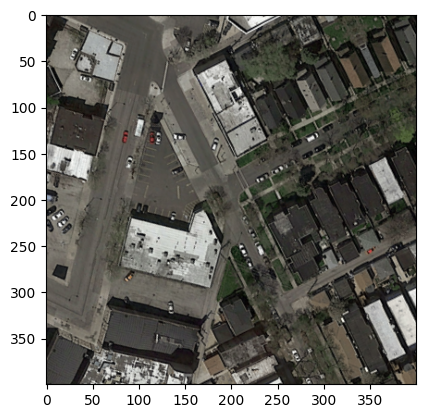

In [28]:
plt.imshow(augmented_image)

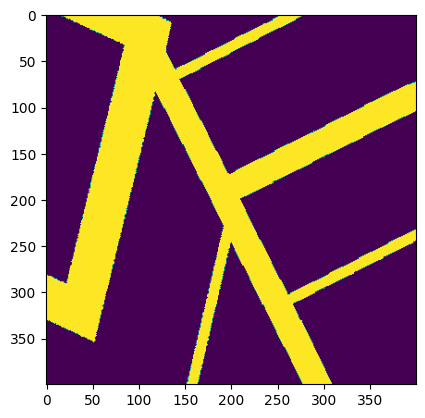

In [29]:
plt.imshow(augmented_groundtruth)

#### By Flipping

In [30]:
def data_augmentation_flip(image, groundtruth, horonzital = True):
    '''Create new image by flipping the image
    Arguments : 
        - image : input image of shape (H,W) that we want to augment
        - groundtruth : segmentation map of the corresponding input image
        - horonzital : flip horizontally the image if True, flip vertically the image if False
    Return :
        - flipped_image : images flipped 
        - flipped_groundtruth : associated segmentation map flipped
    '''

    # Shape of the image on which the segmentation map is placed
    # The shape of the segmentation map array is identical to the image shape
    shape_image = groundtruth.shape  # (400,400)

    # Object representing a segmentation map associated with an image
    seg_map =  SegmentationMapsOnImage(groundtruth, shape=shape_image)

    # Flip the image
    if horonzital :
        seq = iaa.Sequential([
                            iaa.flip.HorizontalFlip(1)  # Flip the image horizontally
                            ]) 
    else : 
        seq = iaa.Sequential([
                            iaa.flip.VerticalFlip(1)  # Flip the image vertically
                            ])
    
    # Flipping the image
    flipped_image, flipped_groundtruth = seq(image=image, segmentation_maps=seg_map)
    # The flipped segmentation map is converted back to an array
    flipped_groundtruth = 255 * flipped_groundtruth.get_arr().astype('uint8')

    return flipped_image, flipped_groundtruth

In [31]:
flipped_image_h, flipped_groundtruth_h = data_augmentation_flip(imgs[0], gt_imgs[0], True)

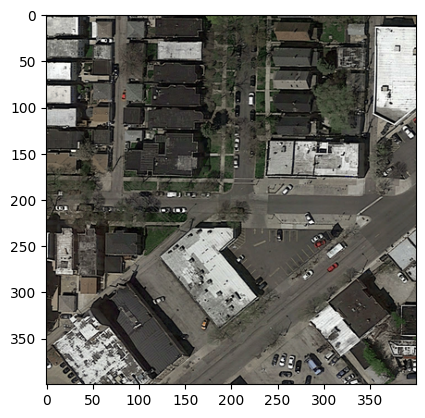

In [32]:
plt.imshow(flipped_image_h)

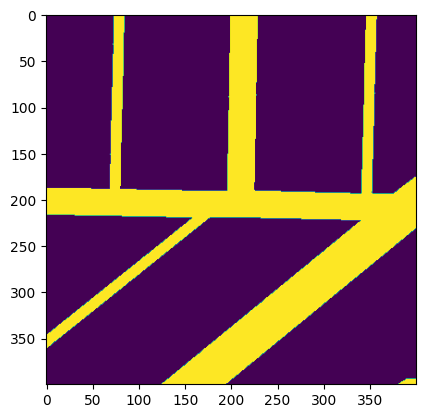

In [33]:
plt.imshow(flipped_groundtruth_h)

In [34]:
flipped_image_v, flipped_groundtruth_v = data_augmentation_flip(imgs[0], gt_imgs[0], False)

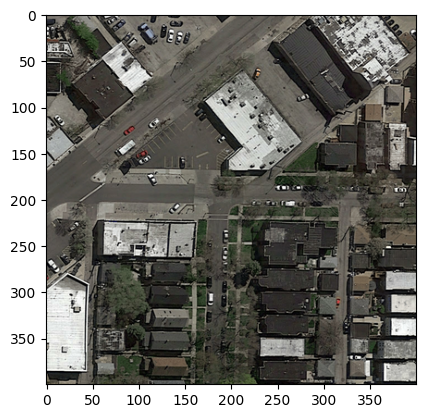

In [35]:
plt.imshow(flipped_image_v)

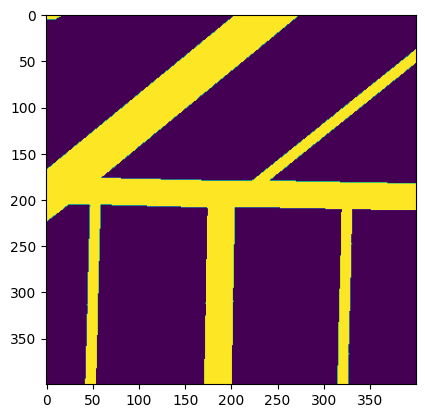

In [36]:
plt.imshow(flipped_groundtruth_v)

### Saving the new images

In [37]:

def save_data_augmented(augmented_image, augmented_groundtruth):
    '''Save the new data generated by augmentation
    Arguments :
        - augmented_image :
        - augmented_groundtruth : 
    '''


    files_augmented = os.listdir(IMAGE_DIR_AUGMENTED)
    a = len(files_augmented)

    files = os.listdir(IMAGE_DIR)
    n = len(files)

    # Path with the name
    image_name = IMAGE_DIR_AUGMENTED + "satImage_" + str(a+1).zfill(3) + ".png"
    groundtruth_name = GT_DIR_AUGMENTED + "satImage_" + str(a+1).zfill(3) + ".png"

    # Save the image and the groundtruth in the augmented directories
    Image.fromarray((augmented_image * 255).astype(np.uint8)).save(image_name)
    Image.fromarray(augmented_groundtruth).save(groundtruth_name)
    



### Augmentation for all

In [38]:
def data_augmented(images, groundtruths):
    '''Augment the number of input images by rotation and flip
    Arguments :
         - images : list of image
         - groundtruths : list of groundtruth
    '''

    n = len(images)

    for i in range(n):
        augmented_image, augmented_groundtruth = data_augmentation_rotation(images[i], groundtruths[i], degree = 45)
        flipped_image_h, flipped_groundtruth_h = data_augmentation_flip(images[i], groundtruths[i], horonzital = True)
        flipped_image_v, flipped_groundtruth_v = data_augmentation_flip(images[i], groundtruths[i], horonzital = False)

        # Saving the new images and groundtruths
        save_data_augmented(augmented_image, augmented_groundtruth)
        save_data_augmented(flipped_image_h, flipped_groundtruth_h)
        save_data_augmented(flipped_image_v, flipped_groundtruth_v)

In [39]:
data_augmented(imgs, gt_imgs)

### More Complex Augmentation

In [40]:

def data_augmentation_complex(image, groundtruth):
    '''Create new image by diverses modifications
    Arguments : 
        - image : input image of shape (H,W) that we want to augment
        - groundtruth : segmentation map of the corresponding input image
    Return :
        - augmented_image : image augmented 
        - augmented_groundtruth : associated segmentation map rotated

    '''
    # Shape of the image on which the segmentation map is placed
    # The shape of the segmentation map array is identical to the image shape
    shape_image = groundtruth.shape  # (400,400)

    # Object representing a segmentation map associated with an image
    seg_map =  SegmentationMapsOnImage(groundtruth, shape=shape_image)
    
    augmenter = iaa.Affine(
                            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                            rotate=(-90, 90),
                            mode = 'symmetric',
                            shear=(-8, 8)
                            )
    augmenter._mode_segmentation_maps = 'symmetric'
    
    # Augmentation sequence
    seq = iaa.Sequential([
                        iaa.Fliplr(0.5), # horizontal flips with probability equals to 0.5
                        iaa.Flipud(0.5), # vertical flips with probability equals to 0.5
                        iaa.Crop(percent=(0, 0.1)), # random crops
                        # Apply affine transformations :
                        augmenter
                        ], random_order=True) # apply augmenters in random order
    
    
    
    # Augmentation
    augmented_image, augmented_groundtruth = seq(image=image, segmentation_maps=seg_map)
    # The augmented segmentation map is converted back to an array
    augmented_groundtruth = 255 * augmented_groundtruth.get_arr().astype('uint8')

    return augmented_image, augmented_groundtruth

In [41]:
augmented_image_complex, augmented_groundtruth_complex = data_augmentation_complex(imgs[0], gt_imgs[0])

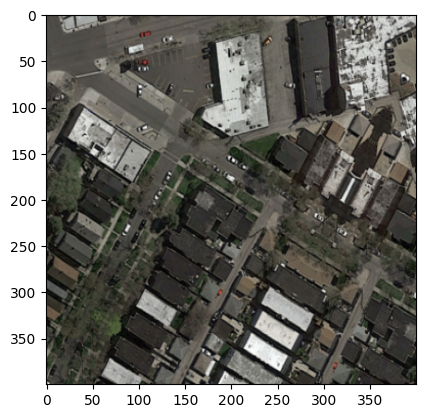

In [42]:
plt.imshow(augmented_image_complex)

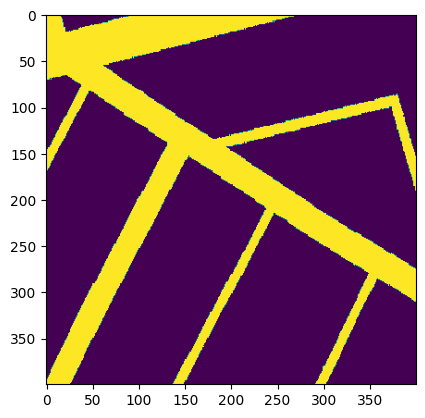

In [43]:
plt.imshow(augmented_groundtruth_complex)

In [44]:
def data_augmented_complex(images, groundtruths, number):
    '''Augment the number of input images by rotation and flip
    Arguments :
         - images : list of image
         - groundtruths : list of groundtruth
    '''
    for i in range(len(images)):
        save_data_augmented(images[i], groundtruths[i])
    
    n = len(images)
    for nb in range(number):
        for i in range(n):
            augmented_image, augmented_groundtruth = data_augmentation_complex(images[i], groundtruths[i])

            # Saving the new images and groundtruths
            save_data_augmented(augmented_image, augmented_groundtruth)


    

In [46]:
data_augmented_complex(imgs, gt_imgs, number = 7)

OSError: cannot write mode F as PNG